In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from urllib.parse import urlparse
import re

import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/capstone/'

In [5]:
ph_df = pd.read_csv(os.path.join(workspace_path, 'phishing_url.csv'), sep=',', header=0, engine='python')
norm_df = pd.read_csv(os.path.join(workspace_path, 'normal_url.csv'), sep=',', header=0, engine='python')

In [6]:
ph_df.shape

(1452, 2)

In [7]:
norm_df.shape

(1307, 2)

In [8]:
ph_df.rename(columns={'Extracted Link': 'url'}, inplace=True)
norm_df.rename(columns={'Extracted Link': 'url'}, inplace=True)

In [9]:
from urllib.parse import urlparse

# 피처 추출 함수
def extract_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc  # 도메인 부분 추출

    features = {
        'contains_at': '@' in url,
        'contains_dash': '-' in url,
        'url_length': len(domain),  # 도메인 길이 계산
        'is_https': url.startswith('https://'),
        'digit_count': sum(c.isdigit() for c in url),
        'double_slash': url.count('//') > 1,
        'is_shortened': any(shortener in url for shortener in ['bit.ly', 'goo.gl', 'tinyurl.com']),
        'subdomain_count': domain.count('.') - 1 if domain.startswith('www.') else domain.count('.')
    }
    return features


def extract_features2(url):
    features = {}
    parsed_url = urlparse(url)

    # 1. 웹사이트 생성 날짜
    try:
        domain_info = whois.whois(parsed_url.netloc)
        features['creation_date'] = domain_info.creation_date
    except Exception:
        features['creation_date'] = None

    # 2. URL 내용이 소스코드 내에 포함
    try:
        response = requests.get(url, timeout=5)
        features['url_in_source'] = url in response.text
    except Exception:
        features['url_in_source'] = False

    # 3. 비표준 포트 사용
    port = parsed_url.port
    features['non_standard_port'] = port not in [None, 80, 443]

    # 4. HTML 소스코드 길이
    try:
        features['source_code_length'] = len(response.text)
    except Exception:
        features['source_code_length'] = None

    return features


# 데이터프레임에 피처 추출 적용 함수
def extract_features_from_dataframe(df):
    features_list = []
    for url in df['url']:
        features = extract_features(url)
        # features2 = extract_features2(url)
        # features.update(features2)
        features_list.append(features)

    features_df = pd.DataFrame(features_list)
    return features_df

In [10]:
# 피처 추출
ph_features_df = extract_features_from_dataframe(ph_df)
norm_features_df = extract_features_from_dataframe(norm_df)

In [11]:

# 피싱 및 정상 데이터셋에 레이블 추가
ph_features_df['label'] = 1  # 피싱 URL
norm_features_df['label'] = 0  # 정상 URL

In [18]:
# 데이터셋 병합
ph_val = ph_features_df.sample(n=100, random_state=42)
ph_train = ph_features_df.drop(ph_val.index)

norm_val = norm_features_df.sample(n=100, random_state=42)
norm_train = norm_features_df.drop(norm_val.index)

valset = pd.concat([ph_val, norm_val])
df = pd.concat([ph_train, norm_train], ignore_index=True)

In [19]:
df.head()

,contains_at,contains_dash,url_length,is_https,digit_count,double_slash,is_shortened,subdomain_count,label
0,False,False,19,True,5,False,False,3,1
1,False,False,22,False,0,False,False,2,1
2,False,True,15,True,15,False,False,2,1
3,False,True,17,True,0,False,False,1,1
4,False,False,26,True,0,False,False,2,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   contains_at      2559 non-null   bool 
 1   contains_dash    2559 non-null   bool 
 2   url_length       2559 non-null   int64
 3   is_https         2559 non-null   bool 
 4   digit_count      2559 non-null   int64
 5   double_slash     2559 non-null   bool 
 6   is_shortened     2559 non-null   bool 
 7   subdomain_count  2559 non-null   int64
 8   label            2559 non-null   int64
dtypes: bool(5), int64(4)
memory usage: 92.6 KB


In [21]:
df_corr = df.corr(method='pearson')
df_corr

,contains_at,contains_dash,url_length,is_https,digit_count,double_slash,is_shortened,subdomain_count,label
contains_at,1.000000,0.015785,-0.021605,0.019001,-0.006036,-0.005263,-0.004262,-0.002013,-0.036259
contains_dash,0.015785,1.000000,0.224912,0.060746,0.220519,0.100522,-0.084122,0.156911,0.023257
url_length,-0.021605,0.224912,1.000000,0.085328,0.204044,0.131250,-0.138681,0.659447,0.287744
is_https,0.019001,0.060746,0.085328,1.000000,-0.001014,-0.013016,-0.028768,-0.002431,0.066544
digit_count,-0.006036,0.220519,0.204044,-0.001014,1.000000,0.408732,-0.032390,0.445639,-0.191154
double_slash,-0.005263,0.100522,0.131250,-0.013016,0.408732,1.000000,-0.019111,0.342229,-0.152157
is_shortened,-0.004262,-0.084122,-0.138681,-0.028768,-0.032390,-0.019111,1.000000,-0.091013,-0.106104
subdomain_count,-0.002013,0.156911,0.659447,-0.002431,0.445639,0.342229,-0.091013,1.000000,0.113724
label,-0.036259,0.023257,0.287744,0.066544,-0.191154,-0.152157,-0.106104,0.113724,1.000000


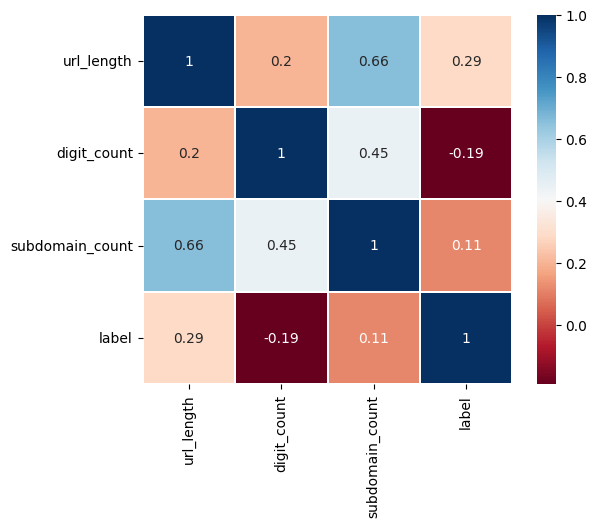

In [22]:
heatmap_data = df.select_dtypes(include=[np.number])
colormap = plt.cm.RdBu
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True,
            annot_kws={'size': 10})
plt.show()

# Logistic 회귀 모델

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X1 = df.drop(columns=['label'])
y1 = df['label']

val_input1 = valset.drop(columns=['label'])
val_target1 = valset['label']

# 학습 데이터와 테스트 데이터로 분할
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [24]:
# 로지스틱 회귀 모델 생성 및 학습
logistic_model = LogisticRegression()
logistic_model.fit(X_train1, y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [25]:
# 모델 평가
y_pred1 = logistic_model.predict(X_test1)

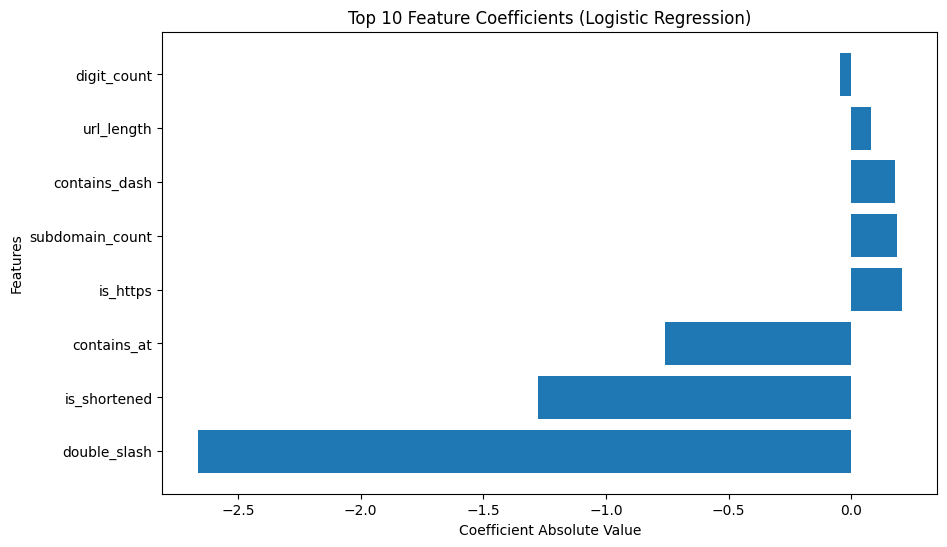

In [26]:
import matplotlib.pyplot as plt

# 학습된 로지스틱 회귀 모델의 계수
coefficients = logistic_model.coef_[0]

# 각 피처와 그 계수를 연결
feature_names = X_train1.columns
coefficients_dict = dict(zip(feature_names, coefficients))

# 계수의 절대값을 기준으로 내림차순 정렬
sorted_coefficients = sorted(coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# 상위 N개의 피처만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_coefficients[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Coefficient Absolute Value')
plt.ylabel('Features')
plt.title('Top {} Feature Coefficients (Logistic Regression)'.format(top_n))
plt.show()


In [27]:
# 정확도 출력
accuracy = accuracy_score(y_test1, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.69921875


In [28]:
# 분류 보고서 출력
classification_rep1 = classification_report(y_test1, y_pred1)
print("Classification Report:\n", classification_rep1)


Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67       238
           1       0.71      0.74      0.72       274

    accuracy                           0.70       512
   macro avg       0.70      0.70      0.70       512
weighted avg       0.70      0.70      0.70       512



In [29]:
# 혼동 행렬 출력
conf_matrix1 = confusion_matrix(y_test1, y_pred1)
print("Confusion Matrix:\n", conf_matrix1)

Confusion Matrix:
 [[155  83]
 [ 71 203]]


In [30]:
# 검증데이터 평가
val_pred1 = logistic_model.predict(val_input1)

In [31]:
# 정확도 출력
accuracy = accuracy_score(val_target1, val_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.695


In [32]:
# 분류 보고서 출력
classification_val1 = classification_report(val_target1, val_pred1)
print("Classification Report:\n", classification_val1)


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68       100
           1       0.68      0.73      0.71       100

    accuracy                           0.69       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.69      0.69       200



In [33]:
# 혼동 행렬 출력
conf_matrix11 = confusion_matrix(val_target1, val_pred1)
print("Confusion Matrix:\n", conf_matrix11)

Confusion Matrix:
 [[66 34]
 [27 73]]


# LGBM 모델

In [35]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X2 = df.drop(columns=['label'])
y2 = df['label']
val_input2 = valset.drop(columns=['label'])
val_target2 = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input2.columns = val_input2.columns.str.replace('[^a-zA-Z0-9]', '_')
X2.columns = X2.columns.str.replace('[^a-zA-Z0-9]', '_')

# 학습 데이터와 테스트 데이터로 분할
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# LightGBM 데이터셋 생성
train_data2 = lgb.Dataset(X_train2, label=y_train2)
test_data2 = lgb.Dataset(X_test2, label=y_test2, reference=train_data2)

# LightGBM 모델 설정 (나머지 코드는 이전과 동일)
params = {
    'objective': 'binary',  # 이진 분류 설정
    'metric': 'binary_error',  # 이진 분류 정확도 측정
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # 트리의 최대 잎 노드 수
    'learning_rate': 0.05,  # 학습률
    'feature_fraction': 0.9,  # 각 트리에서 사용할 피처 비율
}

<ipython-input-35-e9cec84fb0bb>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  val_input2.columns = val_input2.columns.str.replace('[^a-zA-Z0-9]', '_')
<ipython-input-35-e9cec84fb0bb>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  X2.columns = X2.columns.str.replace('[^a-zA-Z0-9]', '_')


In [36]:
# LightGBM 모델 학습
num_round = 10  # 트리 수 (조정 가능)
lgb_model = lgb.train(params, train_data2, num_round)

[LightGBM] [Info] Number of positive: 1078, number of negative: 969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 2047, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526624 -> initscore=0.106598
[LightGBM] [Info] Start training from score 0.106598


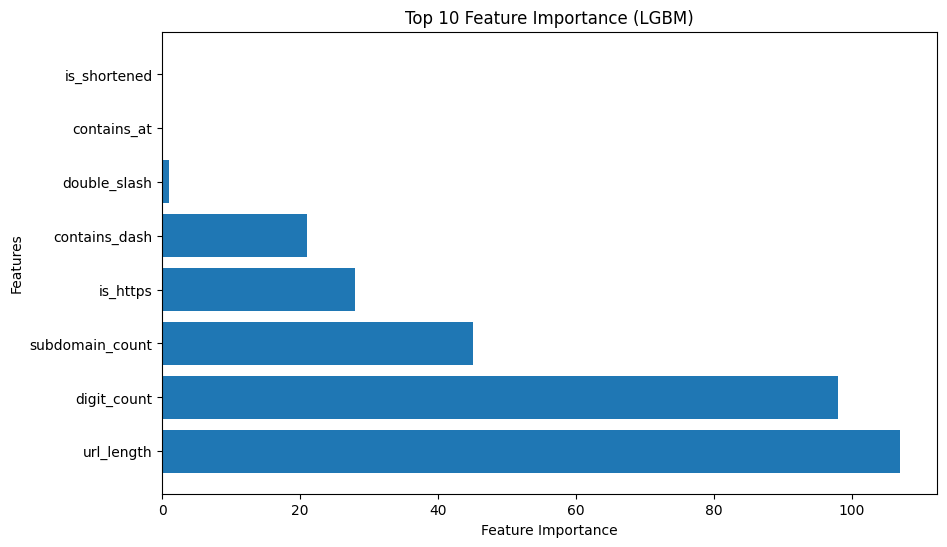

In [37]:
import matplotlib.pyplot as plt

# LightGBM 모델에서 피쳐 중요도 가져오기
feature_importance = lgb_model.feature_importance()
feature_names = X_train2.columns

# 중요도를 피쳐 이름과 연결
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피쳐만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (LGBM)'.format(top_n))
plt.show()


In [38]:
# 모델 예측
y_pred2 = lgb_model.predict(X_test2, num_iteration=lgb_model.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred2]  # 이진 예측

In [39]:
# 정확도 출력
accuracy = accuracy_score(y_test2, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.75390625


In [43]:
# 분류 보고서 출력
classification_rep2 = classification_report(y_test2, y_pred_binary)
print("Classification Report:\n", classification_rep2)

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       238
           1       0.75      0.81      0.78       274

    accuracy                           0.75       512
   macro avg       0.75      0.75      0.75       512
weighted avg       0.75      0.75      0.75       512



In [44]:
# 혼동 행렬 출력
conf_matrix2 = confusion_matrix(y_test2, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix2)

Confusion Matrix:
 [[164  74]
 [ 52 222]]


In [45]:
# 검증 데이터 예측
val_pred2 = lgb_model.predict(val_input2, num_iteration=lgb_model.best_iteration)
val_pred_binary = [1 if pred > 0.5 else 0 for pred in val_pred2]  # 이진 예측

In [46]:
len(val_pred_binary)

200

In [47]:
# 정확도 출력
accuracy = accuracy_score(val_target2, val_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.755


In [48]:
# 분류 보고서 출력
classification_val22 = classification_report(val_target2, val_pred_binary)
print("Classification Report:\n", classification_val22)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.70      0.74       100
           1       0.73      0.81      0.77       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.75       200



# RandomForest

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X3 = df.drop(columns=['label'])
y3 = df['label']

val_input3 = valset.drop(columns=['label'])
val_target3 = valset['label']


In [51]:
# 학습 데이터와 테스트 데이터로 분할
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [52]:
# 랜덤 포레스트 모델 생성 및 학습
rf_model3 = RandomForestClassifier(random_state=42)
rf_model3.fit(X_train3, y_train3)

RandomForestClassifier(random_state=42)

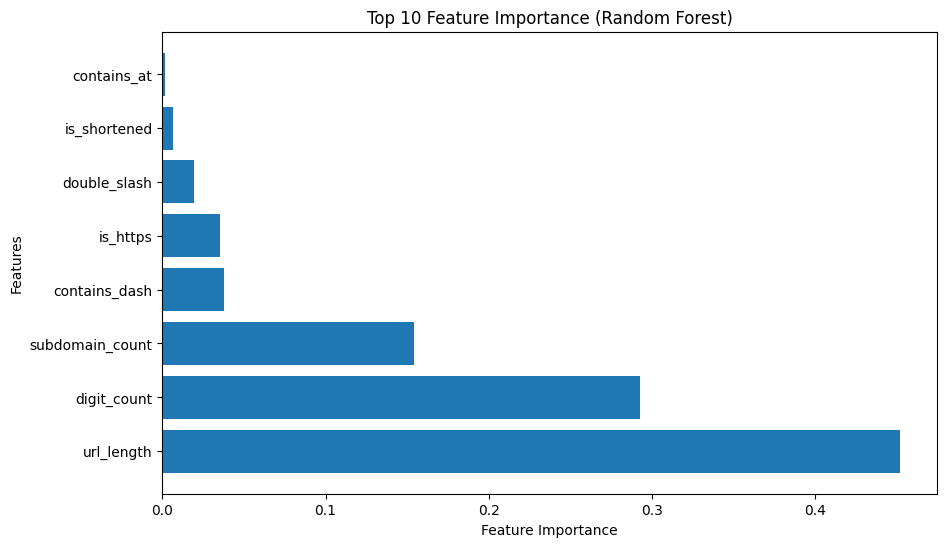

In [53]:
import matplotlib.pyplot as plt

# 학습된 Random Forest 모델에서 피처 중요도 가져오기
feature_importance = rf_model3.feature_importances_

# 각 피처와 그 중요도를 연결
feature_names = X_train3.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피처만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (Random Forest)'.format(top_n))
plt.show()


In [54]:
# 모델 예측
y_pred3 = rf_model3.predict(X_test3)

In [55]:
# 정확도 출력
accuracy = accuracy_score(y_test3, y_pred3)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_rep = classification_report(y_test3, y_pred3)
print("Classification Report:\n", classification_rep)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test3, y_pred3)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.798828125
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77       238
           1       0.79      0.85      0.82       274

    accuracy                           0.80       512
   macro avg       0.80      0.80      0.80       512
weighted avg       0.80      0.80      0.80       512

Confusion Matrix:
 [[177  61]
 [ 42 232]]


In [56]:
# 모델 예측
val_pred3 = rf_model3.predict(val_input3)

In [57]:
# 정확도 출력
accuracy = accuracy_score(val_target3, val_pred3)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_val3 = classification_report(val_target3, val_pred3)
print("Classification Report:\n", classification_val3)

# 혼동 행렬 출력
conf_matrix33 = confusion_matrix(y_test3, y_pred3)
print("Confusion Matrix:\n", conf_matrix33)

Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       100
           1       0.79      0.79      0.79       100

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200

Confusion Matrix:
 [[177  61]
 [ 42 232]]


# SVM

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X4 = df.drop(columns=['label'])
y4 = df['label']

val_input4 = valset.drop(columns=['label'])
val_target4 = valset['label']

In [60]:
# 학습 데이터와 테스트 데이터로 분할
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)

In [61]:
# SVM 모델 생성 및 학습
svm_model = SVC(random_state=42)
svm_model.fit(X_train4, y_train4)

SVC(random_state=42)

In [62]:
# 모델 예측
y_pred4 = svm_model.predict(X_test4)

# 정확도 출력
accuracy = accuracy_score(y_test4, y_pred4)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_rep = classification_report(y_test4, y_pred4)
print("Classification Report:\n", classification_rep)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test4, y_pred4)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.673828125
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66       238
           1       0.70      0.67      0.69       274

    accuracy                           0.67       512
   macro avg       0.67      0.67      0.67       512
weighted avg       0.68      0.67      0.67       512

Confusion Matrix:
 [[161  77]
 [ 90 184]]


In [63]:
# 검증 데이터 예측
val_pred4 = svm_model.predict(val_input4)

# 정확도 출력
accuracy = accuracy_score(val_target4, val_pred4)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_val4 = classification_report(val_target4, val_pred4)
print("Classification Report:\n", classification_val4)

# 혼동 행렬 출력
conf_matrix44 = confusion_matrix(val_target4, val_pred4)
print("Confusion Matrix:\n", conf_matrix44)

Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.70      0.69       100
           1       0.69      0.66      0.67       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200

Confusion Matrix:
 [[70 30]
 [34 66]]


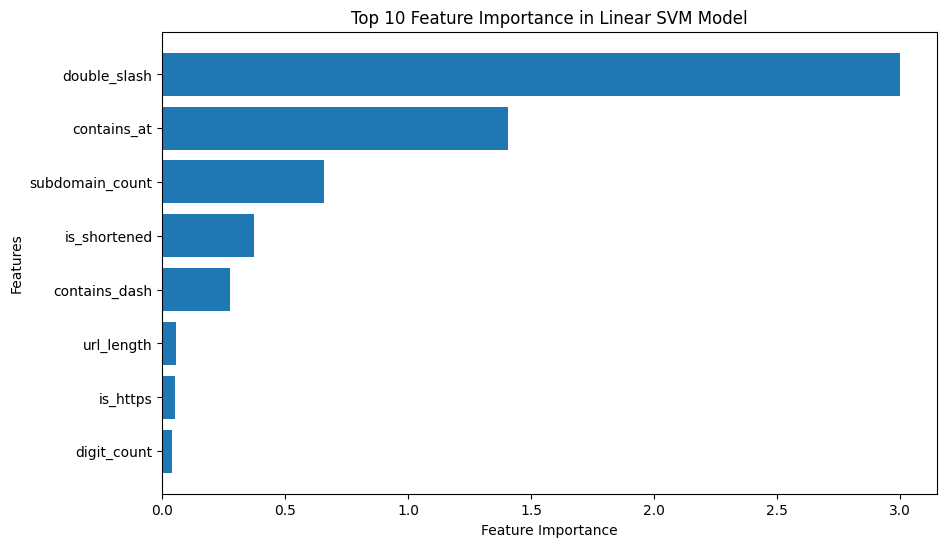

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# 선형 SVM 모델 생성 및 학습
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train4, y_train4)

# 모델 계수를 가져옵니다
coefs = np.abs(svm_model.coef_[0])

# 피처 이름과 계수를 연결
feature_names = X_train4.columns
feature_importance_dict = dict(zip(feature_names, coefs))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피처만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(list(top_features.keys()), list(top_features.values()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance in Linear SVM Model')
plt.gca().invert_yaxis() # 피처를 중요도 높은 순으로 표시
plt.show()

# LSTM

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 데이터 준비 (독립 변수와 종속 변수 분리)
X5 = df.drop(columns=['label'])
y5 = df['label']

val_input5 = valset.drop(columns=['label'])
val_target5 = valset['label']


# 학습 데이터와 테스트 데이터로 분할
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)

# 데이터 전처리
scaler = StandardScaler()
X_train5 = scaler.fit_transform(X_train5)
X_test5 = scaler.transform(X_test5)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(X_train5.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

# 데이터 형식 조정
X_train5 = X_train5.reshape(X_train5.shape[0], X_train5.shape[1], 1)
X_test5 = X_test5.reshape(X_test5.shape[0], X_test5.shape[1], 1)

# 모델 학습
model.fit(X_train5, y_train5, epochs=10, batch_size=64)

Epoch 1/10
32/32 [==============================] - 13s 54ms/step - loss: 0.6882 - accuracy: 0.5491
Epoch 2/10
32/32 [==============================] - 2s 70ms/step - loss: 0.6815 - accuracy: 0.5681
Epoch 3/10
32/32 [==============================] - 2s 62ms/step - loss: 0.6767 - accuracy: 0.5782
Epoch 4/10
32/32 [==============================] - 2s 67ms/step - loss: 0.6728 - accuracy: 0.5871
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.6698 - accuracy: 0.5942
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.6667 - accuracy: 0.5853
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.6650 - accuracy: 0.5910
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.6619 - accuracy: 0.5873
Epoch 9/10
32/32 [==============================] - 1s 38ms/step - loss: 0.6612 - accuracy: 0.5852
Epoch 10/10
32/32 [==============================] - 1s 39ms/step - loss: 0.6575 - accuracy: 0.5968


In [87]:
# 모델 평가
y_pred5 = model.predict(X_test5)

# y_pred5의 첫 번째 차원을 유지하고 나머지 차원을 제거
y_pred5_squeezed = np.squeeze(y_pred5)

print(y_pred5_squeezed.shape)

16/16 [==============================] - 1s 17ms/step
(512, 8)


In [88]:
# 만약 여전히 y_pred5_squeezed가 다차원 배열이라면, 추가적인 처리가 필요
if y_pred5_squeezed.ndim > 1:
    # 예를 들어, y_pred5_squeezed가 2차원 배열이라면, 적절한 열 선택
    y_pred5_squeezed = y_pred5_squeezed[:, 0]  # 예를 들어 첫 번째 열을 선택

# 이진 예측 생성
y_pred_binary5 = [1 if pred > 0.5 else 0 for pred in y_pred5_squeezed]

# 정확도 계산
accuracy = accuracy_score(y_test5, y_pred_binary5)
print("Accuracy:", accuracy)

Accuracy: 0.53515625


In [89]:

# 혼동 행렬
conf_matrix = confusion_matrix(y_test5, y_pred_binary5)
print("Confusion Matrix:")
print(conf_matrix)

# 분류 보고서
class_report = classification_report(y_test5, y_pred_binary5)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[  0 238]
 [  0 274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       238
           1       0.54      1.00      0.70       274

    accuracy                           0.54       512
   macro avg       0.27      0.50      0.35       512
weighted avg       0.29      0.54      0.37       512



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
# 모델 평가
val_pred5 = model.predict(val_input5)

# y_pred5의 첫 번째 차원을 유지하고 나머지 차원을 제거
val_pred5_squeezed = np.squeeze(val_pred5)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type bool).

In [91]:
# 만약 여전히 y_pred5_squeezed가 다차원 배열이라면, 추가적인 처리가 필요
if val_pred5_squeezed.ndim > 1:
    # 예를 들어, y_pred5_squeezed가 2차원 배열이라면, 적절한 열 선택
    val_pred5_squeezed = val_pred5_squeezed[:, 2]  # 예를 들어 첫 번째 열을 선택

# 이진 예측 생성
val_pred_binary5 = [1 if pred > 0.5 else 0 for pred in val_pred5_squeezed]

# 정확도 계산
accuracy = accuracy_score(val_target5, val_pred_binary5)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_val5 = classification_report(val_target5, val_pred_binary5)
print("Classification Report:\n", classification_val5)

# 혼동 행렬 출력
conf_matrix55 = confusion_matrix(val_target5, val_pred_binary5)
print("Confusion Matrix:\n", conf_matrix55)

NameError: name 'val_pred5_squeezed' is not defined

# 모델 비교평가

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = y_test1
y_pred_lgbm = y_pred_binary
y_pred_logistic = y_pred1
y_pred_rf = y_pred3
y_pred_lstm = y_pred_binary5
y_pred_svm = y_pred4

# 각 모델의 성능 지표 계산
models = ['LightGBM', 'Logistic Regression', 'Random Forest', 'LSTM', 'SVM']
y_preds = [y_pred_lgbm, y_pred_logistic, y_pred_rf, y_pred_lstm, y_pred_svm]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


LightGBM - Accuracy: 0.75, Precision: 0.75, Recall: 0.81, F1 Score: 0.78
Logistic Regression - Accuracy: 0.70, Precision: 0.71, Recall: 0.74, F1 Score: 0.72
Random Forest - Accuracy: 0.80, Precision: 0.79, Recall: 0.85, F1 Score: 0.82
LSTM - Accuracy: 0.54, Precision: 0.54, Recall: 1.00, F1 Score: 0.70
SVM - Accuracy: 0.67, Precision: 0.70, Recall: 0.67, F1 Score: 0.69


In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = val_target1
y_pred_lgbm = val_pred_binary
y_pred_logistic = val_pred1
y_pred_rf = val_pred3
y_pred_lstm = val_pred_binary5
y_pred_svm = val_pred4

# 각 모델의 성능 지표 계산
models = ['LightGBM', 'Logistic Regression', 'Random Forest', 'LSTM', 'SVM']
y_preds = [y_pred_lgbm, y_pred_logistic, y_pred_rf, y_pred_lstm, y_pred_svm]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


NameError: name 'val_pred_binary5' is not defined